In [157]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler


Chargement des données

-recolte.csv : données de rendement agricole

-climat.csv : données climatiques

-persticide.csv : données sur l’utilisation de pesticides

In [ ]:
df_crop= pd.read_csv('./data/exercice_2/recolte.csv')
df_temp= pd.read_csv('./data/exercice_2/climat.csv')
df_dis= pd.read_csv('./data/exercice_2/persticide.csv')

Préparation et transformation des données

Les colonnes des mois sont supprimées dans les données climatiques pour ne garder que les valeurs annuelles.

In [159]:
mois = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
df_temp = df_temp.drop(columns=mois)

Les données climatiques sont pivotées pour avoir une colonne par paramètre climatique et une ligne par année.

In [160]:
df_temp = df_temp.pivot(index='YEAR', columns='PARAMETER', values='ANN').reset_index()
#df_temp.info()

Les trois jeux de données sont renommés pour avoir des colonnes claires (Year, Rendement, persticide)

In [161]:
df_crop = df_crop[['Year', 'Value']].rename(columns={'Value': 'Rendement'})
df_dis = df_dis[['Year', 'Value']].rename(columns={'Value': 'persticide'})
df_temp=df_temp.rename(columns={'YEAR': 'Year'})

fusion de l'ensemble des données sur la colonne Year pour obtenir un seul tableau qui contient toutes les informations par année

In [162]:
df = pd.merge(df_crop, df_temp, on='Year', how='inner')
df = pd.merge(df, df_dis, on='Year', how='inner')
df.shape

(9034, 16)

Analyse de la corrélation des variables avec le rendement


<ipython-input-163-1ed1b1fe92b3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')


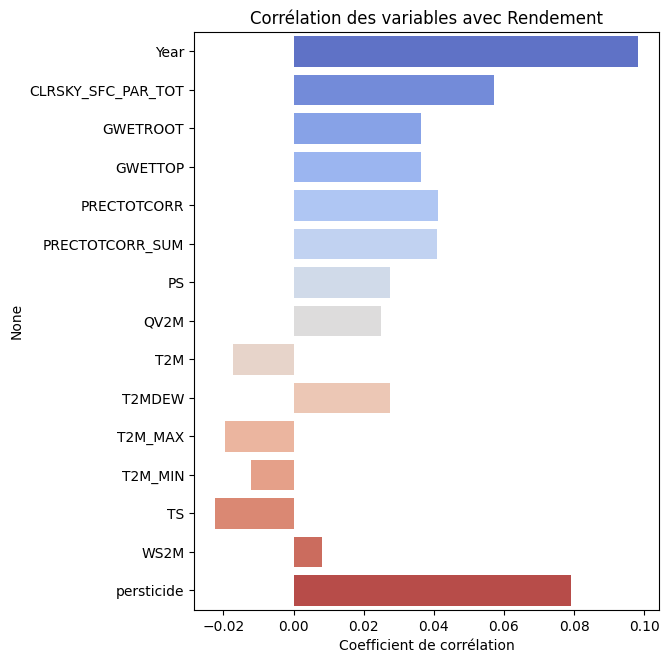

In [163]:

corr_target = df.corr()['Rendement'].drop('Rendement')
plt.figure(figsize=(6, len(corr_target)*0.5))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')
plt.title('Corrélation des variables avec Rendement')
plt.xlabel('Coefficient de corrélation')
plt.show()

Analyse de la corrélation des variables

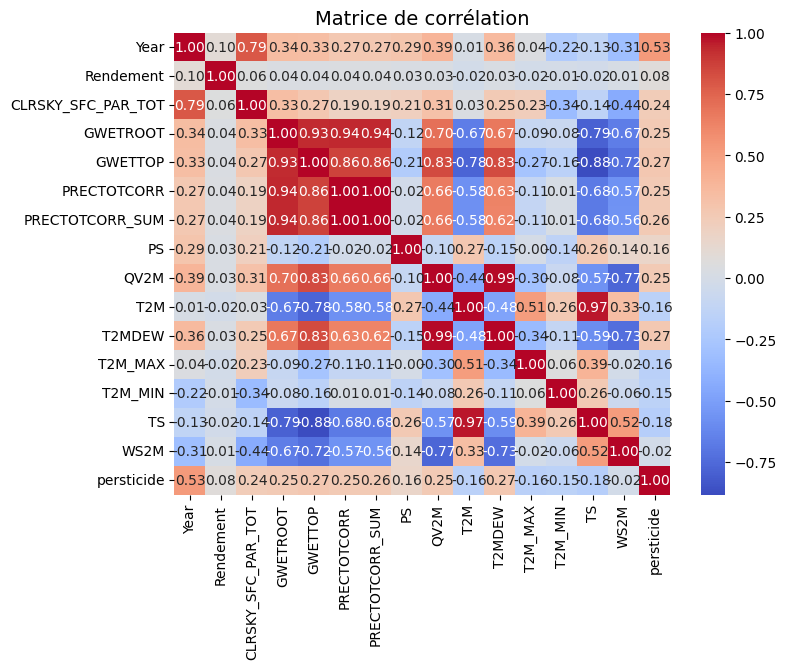

In [164]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation", fontsize=14)
plt.show()

Séparation des variables explicatives (X) et de la variable cible (y)

In [165]:
X = df.drop(columns=['Rendement']).values
y = df['Rendement'].values.reshape(-1, 1)

Standardisation des variables explicatives et de la cible

In [166]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)


scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)


Création des séquences temporelles pour le modèle

La fonction create_sequences sert à transformer des données tabulaires classiques en séquences temporelles adaptées aux réseaux de neurones récurrents (comme LSTM ou GRU), qui sont spécialisés dans le traitement des séries temporelles

In [167]:
def create_sequences(X, y, n_steps=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i+n_steps])
        y_seq.append(y[i+n_steps])
    return np.array(X_seq), np.array(y_seq)

n_steps = 3
X_seq, y_seq = create_sequences(X_scaled, y_scaled, n_steps)


Séparation des données en ensembles d'entraînement et de test

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2,random_state=42)

print(X_train.shape, X_test.shape)


(7224, 3, 15) (1807, 3, 15)


Moyenne de y_test : 0.0020908320006983254
Variance de y_test : 6.555465588366386e-05
Écart-type de y_test : 0.008096582975778354


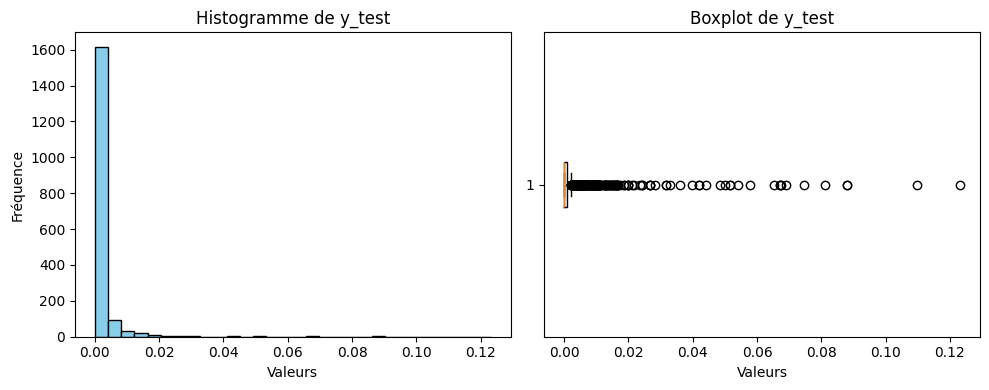

In [169]:
print("Moyenne de y_test :", np.mean(y_test))
print("Variance de y_test :", np.var(y_test))
print("Écart-type de y_test :", np.std(y_test))

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(y_test, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogramme de y_test")
plt.xlabel("Valeurs")
plt.ylabel("Fréquence")

plt.subplot(1,2,2)
plt.boxplot(y_test, vert=False)
plt.title("Boxplot de y_test")
plt.xlabel("Valeurs")

plt.tight_layout()
plt.show()


Construction et entraînement du modèle LSTM

In [170]:
model = Sequential()
model.add(GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')
#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_test, y_test))
#,callbacks=[early_stop]


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0595 - val_loss: 7.7556e-05
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 3.6639e-04 - val_loss: 7.2834e-05
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0013 - val_loss: 6.6917e-05
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6.7842e-04 - val_loss: 6.9177e-05
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.0040e-04 - val_loss: 6.6382e-05
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.8135e-04 - val_loss: 6.7055e-05
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5.0772e-04 - val_loss: 6.7292e-05
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.1676e-04 - val_loss: 6.6380e-05
Epoch 9/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.5296e-04 - val_loss: 6.6358e-05
Epoch 10/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.6955e-04 - val_loss: 7.3929e-05
Epoch 11/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - lo

Prédiction et visualisation des résultats

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[0.00072881]
 [0.00075256]
 [0.00132743]
 ...
 [0.00062738]
 [0.00059456]
 [0.00124696]]
Var y_test : 6.555465588366386e-05


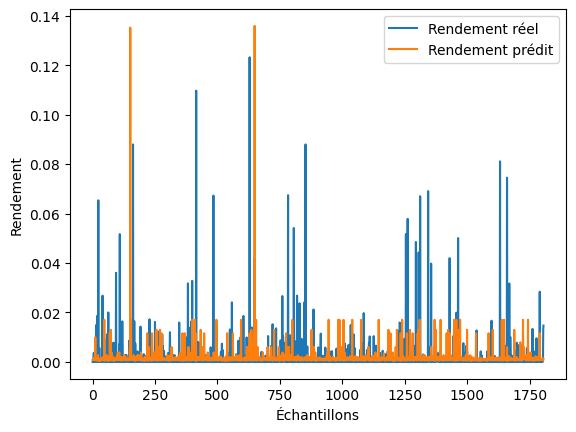

In [171]:
y_pred = model.predict(X_test)
print(y_pred)

plt.plot(y_test, label='Rendement réel')
plt.plot(y_pred, label='Rendement prédit')
plt.xlabel('Échantillons')
plt.ylabel('Rendement')
plt.legend()
plt.show()


Évaluation des performances du modèle

In [172]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE :", rmse)
print("R2 :", r2)

MAE : 0.0028978562526146574
RMSE : 0.00904501600136903
R2 : -0.24800158527579597
